# Exploratory Data Analysis 


##  Data

Dataset: https://www.kaggle.com/olistbr/marketing-funnel-olist


This dataset was generously provided by Olist, the largest department store in Brazilian marketplaces. Olist connects small businesses from all over Brazil to channels without hassle and with a single contract. Those merchants are able to sell their products through the Olist Store and ship them directly to the customers using Olist logistics partners. See more on our website: www.olist.com



In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.dates as md

from matplotlib import style
import seaborn as sns
style.use('fivethirtyeight')
sns.set(style='dark',color_codes=True)



In [2]:
# azureml-core of version 1.0.72 or higher is required
# azureml-dataprep[pandas] of version 1.1.34 or higher is required
from azureml.core import Workspace, Dataset

subscription_id = '71b2b08a-790d-402f-9800-fa9ad29fcb60'
resource_group = 'rg_sm'
workspace_name = 'SM1196'

workspace = Workspace(subscription_id, resource_group, workspace_name)




In [3]:
closed_deals_path = 'olist_closed_deals' 
market_lead_path = 'olist_marketing_qualified_leads'

cd = Dataset.get_by_name(workspace, name=closed_deals_path)
cd = cd.to_pandas_dataframe()

ml = Dataset.get_by_name(workspace, name=market_lead_path)
ml = ml.to_pandas_dataframe()

market_funnel = pd.merge(ml, cd, left_on='mql_id', right_on='mql_id', how='left')

market_funnel.head()


,mql_id,first_contact_date,landing_page_id,origin,seller_id,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,has_company,has_gtin,average_stock,business_type,declared_product_catalog_size,declared_monthly_revenue
0,dac32acd4db4c29c230538b72f8dd87d,2018-02-01,88740e65d5d6b056e0cda098e1ea6313,social,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8c18d1de7f67e60dbd64e3c07d7e9d5d,2017-10-20,007f9098284a86ee80ddeb25d53e0af8,paid_search,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,b4bc852d233dfefc5131f593b538befa,2018-03-22,a7982125ff7aa3b2054c6e44f9d28522,organic_search,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6be030b81c75970747525b843c1ef4f8,2018-01-22,d45d558f0daeecf3cccdffe3c59684aa,email,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5420aad7fec3549a85876ba1c529bd84,2018-02-21,b48ec5f3b04e9068441002a19df93c6c,organic_search,2c43fb513632d29b3b58df74816f1b06,a8387c01a09e99ce014107505b92388c,4ef15afb4b2723d8f3d81e51ec7afefe,2018-02-26 19:58:54,pet,online_medium,cat,None,None,None,reseller,NaN,0.0


In [4]:
# View info

market_funnel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8000 entries, 0 to 7999
Data columns (total 17 columns):
mql_id                           8000 non-null object
first_contact_date               8000 non-null datetime64[ns]
landing_page_id                  8000 non-null object
origin                           7940 non-null object
seller_id                        842 non-null object
sdr_id                           842 non-null object
sr_id                            842 non-null object
won_date                         842 non-null datetime64[ns]
business_segment                 841 non-null object
lead_type                        836 non-null object
lead_behaviour_profile           665 non-null object
has_company                      63 non-null object
has_gtin                         64 non-null object
average_stock                    66 non-null object
business_type                    832 non-null object
declared_product_catalog_size    69 non-null float64
declared_monthly_revenue    

In [5]:

market_funnel = market_funnel[['first_contact_date','origin','seller_id']]

market_funnel['converted'] = market_funnel[['seller_id']].where(market_funnel[['seller_id']].isnull()==True, 1).fillna(0).astype(int)


market_funnel['year'] = pd.DatetimeIndex(market_funnel.first_contact_date).year
market_funnel['month'] = pd.DatetimeIndex(market_funnel.first_contact_date).month
market_funnel['day'] = pd.DatetimeIndex(market_funnel.first_contact_date).day
market_funnel['quarter'] = market_funnel.month.apply(lambda x:x//4)

market_funnel.head()

,first_contact_date,origin,seller_id,converted,year,month,day,quarter
0,2018-02-01,social,NaN,0,2018,2,1,0
1,2017-10-20,paid_search,NaN,0,2017,10,20,2
2,2018-03-22,organic_search,NaN,0,2018,3,22,0
3,2018-01-22,email,NaN,0,2018,1,22,0
4,2018-02-21,organic_search,2c43fb513632d29b3b58df74816f1b06,1,2018,2,21,0


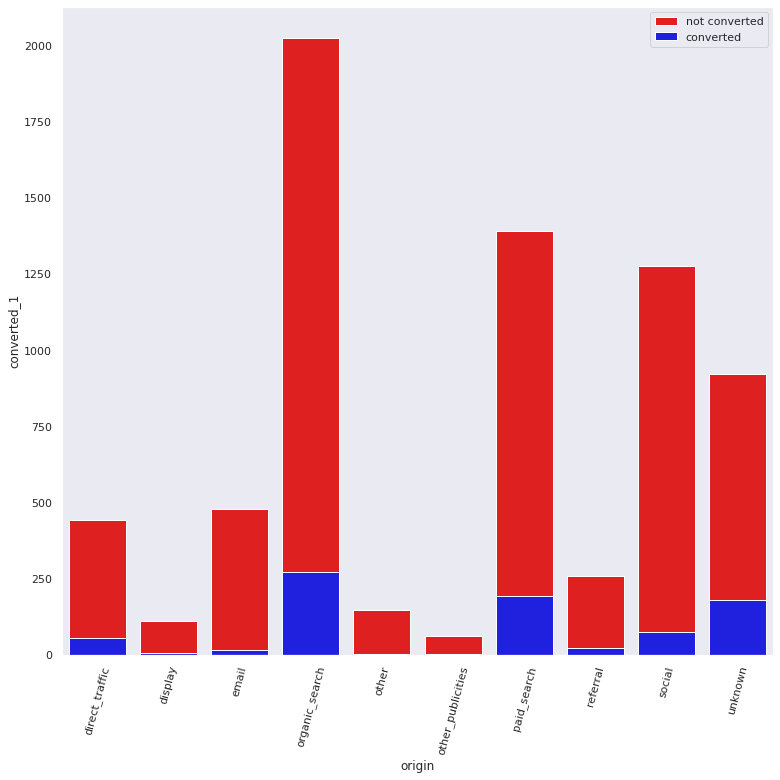

In [6]:
#Visualizing conversion of leads based on origin

df_0 = market_funnel.loc[market_funnel.converted == 0,['origin','converted']].groupby(['origin']).count().reset_index()
df_1 = market_funnel.loc[market_funnel.converted == 1,['origin','converted']].groupby(['origin']).count().reset_index()

df = pd.merge(df_0, df_1, on = 'origin',how='outer',suffixes=('_0','_1')).fillna(0)

plt.figure(figsize=(11,11))

s1 = sns.barplot(x = 'origin', y = 'converted_0', data = df, color = 'red', label = 'not converted')

s2 = sns.barplot(x = 'origin', y = 'converted_1', data = df, color = 'blue', label = 'converted')

plt.legend(loc ="upper right")

plt.xticks(rotation = 75)
plt.tight_layout()


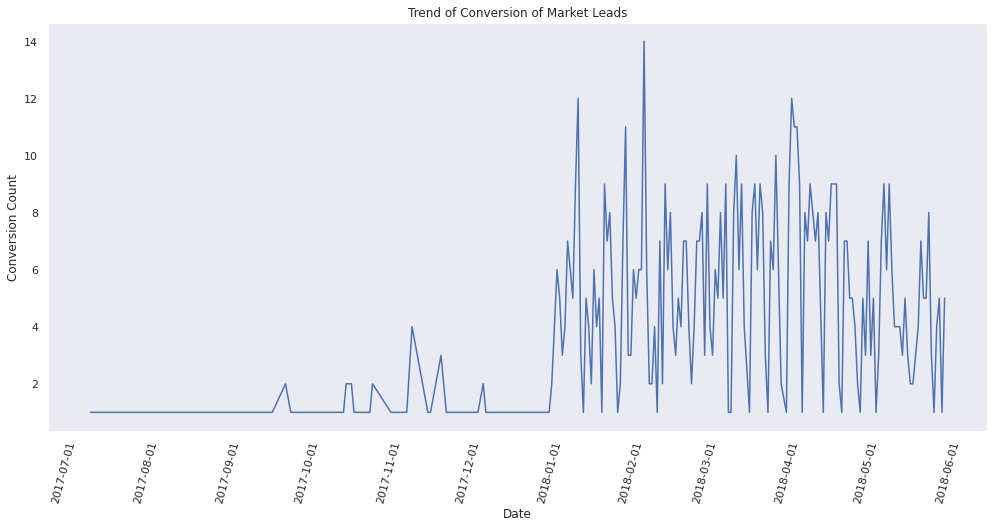

In [8]:
#Visualizing Number of Leads Converted by Date

df_2 = market_funnel.loc[market_funnel.converted == 1,['first_contact_date','converted']].groupby(['first_contact_date']).count().reset_index()

# prepare the figure
fig, ax = plt.subplots(figsize = (15, 7))

# set up the plot
sns.lineplot(ax = ax, x='first_contact_date', y='converted', data=df_2).set_title('Trend of Conversion of Market Leads')

# specify the position of the major ticks at the beginning of the week
ax.xaxis.set_major_locator(md.MonthLocator())
# specify the format of the labels as 'year-month-day'
ax.xaxis.set_major_formatter(md.DateFormatter('%Y-%m-%d'))
# (optional) rotate by 90° the labels in order to improve their spacing
plt.setp(ax.xaxis.get_majorticklabels(), rotation = 75)

# specify the position of the minor ticks at each day
ax.xaxis.set_minor_locator(md.DayLocator(interval = 1))

# set ticks length
ax.tick_params(axis = 'x', which = 'major', length = 5)
ax.tick_params(axis = 'x', which = 'minor', length = 5)

# set axes labels
plt.xlabel('Date')
plt.ylabel('Conversion Count')

# show the plot
plt.show()
